# Classificador de contas contábeis
O objetivo deste projeto é criar um classificador de contas contábeis para ajudar a identificar e categorizar lançamentos financeiros de uma empresa. Nessa primeira etapa, vamos explorar e analisar os dados para entender melhor o problema e identificar as características relevantes para o classificador.

## Quais serão os próximos passos?
- Aumentar a probabilidade de acerto para acima de 70%
- Preencher a conta contábil quando estiver vazia e a probabilidade for maior de 70%. Caso contrário, dê uma sugestão da conta a ser preenchida na coluna "Probabilidade".
- Criar um relatório de classificação com a matriz de confusão
- Preencher a conta contábil e a probabilidade, gerando uma nova planilha com os resultados

## Bibliotecas utilizadas
- Pandas: carregamento, manipulação e tratamento de dados, transformando-os em DataFrame
- Numpy: computação numérica
- Scikit-learn: para o desenvolvimento do projeto (treinamento e avaliação do modelo)
- Nltk: ferramenta para processamento de texto (stopwords)
- Matplotlib e Seaborn: visualização dos dados

In [18]:
# - Bibliotecas para manipulação e análise de dados
import pandas as pd
import numpy as np
import openpyxl

# - Bibliotecas para visualização de dados
import matplotlib.pyplot as plt
import seaborn as sns

# - Bibliotecas para ML
import nltk
nltk.download('stopwords')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# - Configurações de visualização
%matplotlib inline
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## DataFrame com os dados
A planilha a ser utilizada será **teste_contabeis_2024.xlsx**. Ela possui 5 colunas

| Nome da Coluna          | Descrição                                             |
|-------------------------|-------------------------------------------------------|
| CONTA                   | Número da conta contábil.                             |
| BANCO                   | Banco vinculado ao lançamento/conta contábil.         |
| DATA                    | Data do lançamento.                                   |
| DESCRIÇÃO DO LANÇAMENTO | Descrição do lançamento (Ex: Pagto. Salário).         |
| VALOR                   | Valor monetário do lançamento.                        |

Antes de iniciarmos as análises e testes de modelo, vamos verificar nosso *dataset*, analisando as 5 primeiras entradas e as dimensões do mesmo.

In [1]:
# Criando o DataFrame
df = pd.read_excel('teste_contabeis_2024.xlsx')

# Exibindo as primeiras linhas do DataFrame
df.head()

NameError: name 'pd' is not defined

In [ ]:
# Mostrando a dimensão do DataFrame
print(f"O DataFrame possui {df.shape[0]} linhas e {df.shape[1]} colunas.")
print("--------------------------------")
# Informações técnicas do DataFrame
df.info()
print("--------------------------------")
# pegando colunas e colocando em dataset
dataset = df.columns.tolist()
print(dataset)

print("--------------------------------")
# Verificando contas contábeis a serem classificadas
num_classes = df['CONTA'].nunique()
print(f"Número de contas contábeis únicas: {num_classes}")
print("--------------------------------")

O DataFrame possui 1256 linhas e 5 colunas.
--------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1256 entries, 0 to 1255
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   CONTA                    1256 non-null   int64         
 1   BANCO                    1256 non-null   object        
 2   DATA                     1256 non-null   datetime64[ns]
 3   DESCRIÇÃO DO LANÇAMENTO  1256 non-null   object        
 4   VALOR                    1256 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 49.2+ KB
--------------------------------
['CONTA', 'BANCO', 'DATA', 'DESCRIÇÃO DO LANÇAMENTO', 'VALOR']
--------------------------------
Número de contas contábeis únicas: 53
--------------------------------


## Como as contas estão distribuídas?
Criando um *DataFrame* para mostrar a distribuição de lançamentos por conta contábil. Logo em seguida, plotarei esses dados para melhor visualização

Distribuição de lançamentos por conta contábil: 
CONTA
101161    246
30178     210
10722     138
10829     122
10116     110
103921     84
103915     34
50101      32
50291      31
103907     29
20068      27
10001      21
20001      15
103933     15
20951      15
50102      14
12533      13
103905      9
12320       8
101171      6
103919      6
20051       6
50095       5
10532       5
103939      5
103930      4
103904      4
50143       3
103938      3
103950      3
50260       3
103947      2
103941      2
50057       2
50094       2
103931      2
103975      2
50114       2
103942      2
103951      1
103920      1
103962      1
103959      1
50348       1
50244       1
103924      1
10117       1
50126       1
103928      1
103948      1
103932      1
103940      1
103925      1
Name: count, dtype: int64
--------------------------------


/tmp/ipykernel_5896/3781349869.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count_contas.index, y=count_contas.values, palette="viridis")


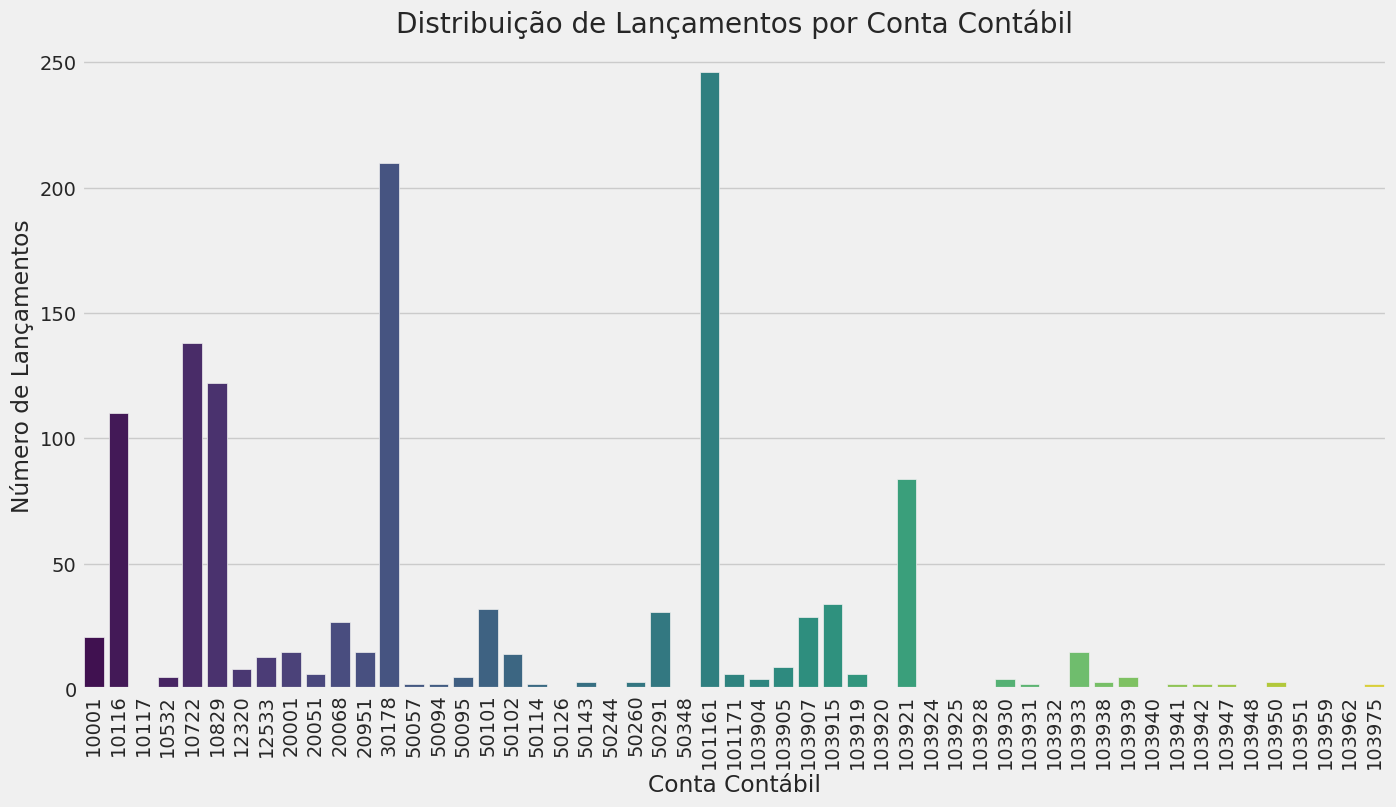

In [21]:
# Montagem de grafico de barras para visualizar a distribuição das classes
print("Distribuição de lançamentos por conta contábil: ")
count_contas = df['CONTA'].value_counts()
print(count_contas)
print("--------------------------------")
# Plotando o gráfico de barras
plt.figure(figsize=(15, 8))
sns.barplot(x=count_contas.index, y=count_contas.values, palette="viridis")
plt.title("Distribuição de Lançamentos por Conta Contábil")
plt.xlabel("Conta Contábil")
plt.ylabel("Número de Lançamentos")
plt.xticks(rotation=90)
plt.show()


## Como podemos tratar o texto para fazer a classificação?
Para tratar o texto, vamos utilizar o *nltk* para limpar o texto com as *stopwords*.

- **Stopwords**: são as palavras mais comuns e frequentes em um idioma ou contexto, que servem como conexão para formar uma oração ou frase. Elas podem ser removidas do texto para melhorar a qualidade da classificação.

O *dataset* a seguir faz a comparação do histórico original com o histórico limpo.

In [22]:
# Tratamento de texto - descrição
import re
from nltk.corpus import stopwords

# função para limpar o texto
def clean_text(text):
    # transformar em minúsculas
    text = str(text).lower()
    # remover numeros
    text = re.sub(r'\d+', ' ', text)
    # remover pontuação e caracteres especiais
    text = re.sub(r'[^\w\s]', ' ', text)
    # remover espaços extras
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)
    # remover stopwords
    stopwords_pt = set(stopwords.words('portuguese'))
    # Opcional: adicionar stopwords condizentes ao contexto
    custom_stopwords = {'Lançamento', 'pagto', 'aplicações'}
    # update
    stopwords_pt.update(custom_stopwords)
    # Separar as palavras
    words = text.split()
    # Remover as stopwords
    words_filtered = [word for word in words if word not in stopwords_pt and len(word) > 2]
    # Juntar as palavras novamente
    clean_text = ' '.join(words_filtered)
    return clean_text

print("Limpando os textos das descrições...")
# Aplicando a função de limpeza ao DataFrame
# Criando uma coluna com o texto limpo
df["DESCRIÇÃO_LIMPA"] = df["DESCRIÇÃO DO LANÇAMENTO"].apply(clean_text)
# Comparação
print("Comparação entre texto original e texto limpo:")
df[["DESCRIÇÃO DO LANÇAMENTO", "DESCRIÇÃO_LIMPA"]].head(10)

Limpando os textos das descrições...
Comparação entre texto original e texto limpo:


,DESCRIÇÃO DO LANÇAMENTO,DESCRIÇÃO_LIMPA
0,PAGTO. BOLETO - ENDURANCE GROUP B H SITES LTDA,boleto endurance group sites ltda
1,VR. RESGATE DE APLICAÇÕES,resgate
2,PAGTO. BOLETO - 33821 ANGLO INDUSTRIA E COMERC...,boleto anglo industria comercio metais ltda
3,VR. RESGATE DE APLICAÇÕES,resgate
4,VR. RENDIMENTO S/APLICAÇÕES,rendimento
5,PAGTO. DE LUCROS A ALEXANDRE PINTO DIAS,lucros alexandre pinto dias
6,VR. APLICAÇÕES.CF.EXTRATOS,extratos
7,RECEBTO.DUPLICATAS,recebto duplicatas
8,PAGTO. NF. 1399744 OMIEXPERIENCE LTDA.,omiexperience ltda
9,VR. RESGATE DE APLICAÇÕES,resgate


## Quais são as palavras mais frequentes?
O *dataset* a seguir mostra as palavras mais frequentes após o tratamento do histórico.

In [23]:
# Análise de frequência das palavras

count_vectorizer = CountVectorizer()
# matriz de contagem de palavras
arr_count = count_vectorizer.fit_transform(df["DESCRIÇÃO_LIMPA"])
# Somando as ocorrências de cada palavra
sum_words = arr_count.sum(axis=0)
# Criando um dicionário de palavras e suas frequências
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vectorizer.vocabulary_.items()]
# Ordenar lista da mais frequente para a menos frequente
words_freq_sorted = sorted(words_freq, key=lambda x: x[1], reverse=True)
# Criando DataFrame
df_words_freq = pd.DataFrame(words_freq_sorted, columns=['Palavra', 'Frequência'])

# Mostrando as palavras mais frequentes
print("Palavras mais frequentes nas descrições limpas:")
df_words_freq.head(50) 

Palavras mais frequentes nas descrições limpas:


,Palavra,Frequência
0,resgate,252
1,rendimento,210
2,boleto,193
3,ltda,184
4,recebto,138
5,duplicatas,138
6,alexandre,137
7,pinto,137
8,dias,137
9,lucros,121


## Criando o modelo
Antes de criar o modelo, é criado um filtro para prepará-lo. A divisão do modelo deve ter estratificação com pelo menos 5 ocorrências por classe. A divisão entre dados é composta por: **70% treino e 30% teste**.
Lembrando que:

##### **X = coluna com histórico**
##### **y = coluna com as contas contábeis**

In [24]:
# Criando filtro para preparar modelo. A divisão do modelo deve ter estratificação com pelo menos 5 ocorrências por classe
count_acc = df['CONTA'].value_counts()
valid_acc = count_acc[count_acc >= 5].index
df_filtered = df[df['CONTA'].isin(valid_acc)]

# Criando primeiro modelo de teste
X = df_filtered["DESCRIÇÃO_LIMPA"]
y = df_filtered["CONTA"]
# Divisão entre dados de treino e teste: 70% treino e 30% teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# Definir e criar pipeline
text_clf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])   
# Treinando o pipeline
text_clf_pipeline.fit(X_train, y_train)
print("Modelo treinado com sucesso!")    

Modelo treinado com sucesso!


# Relatorio de classificação
O relatório nos mostrará o resultado da classificação dividido em 4 colunas:

- **Precision**: de toda a classificação, qual a porcentagem de acertos? (Mede a qualidade da previsão)
- **Recall**: de todos os exemplos que realmente eram de *X*, quantos o modelo conseguiu encontrar? (Mede a quantidade de acertos)
- **F1-Score**: uma média entre *Precision* e *Recall*. Ótima métrica para verificar o balanceamento do *dataset*
- **Accuracy**: Acurácia é a porcentagem de acertos em relação ao total de previsões
(Acurácia = Número de acertos / Número total de amostras)

## Matriz de confusão
Para ter uma visão mais detalhada de onde tivemos acertos e erros, usaremos a Matriz de Confusão

- Linhas representam a conta real
- Colunas representam a conta prevista pelo modelo
- Os números na diagonal principal são os acertos
- Qualquer número fora da diagonal representa um erro de classificação

Relatório de Classificação: 
              precision    recall  f1-score   support

       10001       1.00      1.00      1.00         6
       10116       0.97      1.00      0.99        33
       10532       0.00      0.00      0.00         1
       10722       1.00      1.00      1.00        41
       10829       1.00      1.00      1.00        37
       12320       0.67      1.00      0.80         2
       12533       1.00      1.00      1.00         4
       20001       1.00      0.80      0.89         5
       20051       0.00      0.00      0.00         2
       20068       0.73      1.00      0.84         8
       20951       1.00      1.00      1.00         5
       30178       1.00      1.00      1.00        63
       50095       0.00      0.00      0.00         1
       50101       0.83      1.00      0.91        10
       50102       1.00      1.00      1.00         4
       50291       1.00      1.00      1.00         9
      101161       0.96      1.00      0.98        7

/home/lucas/Documentos/Projetos/classificando-contas-contabeis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/lucas/Documentos/Projetos/classificando-contas-contabeis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/lucas/Documentos/Projetos/classificando-contas-contabeis/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.

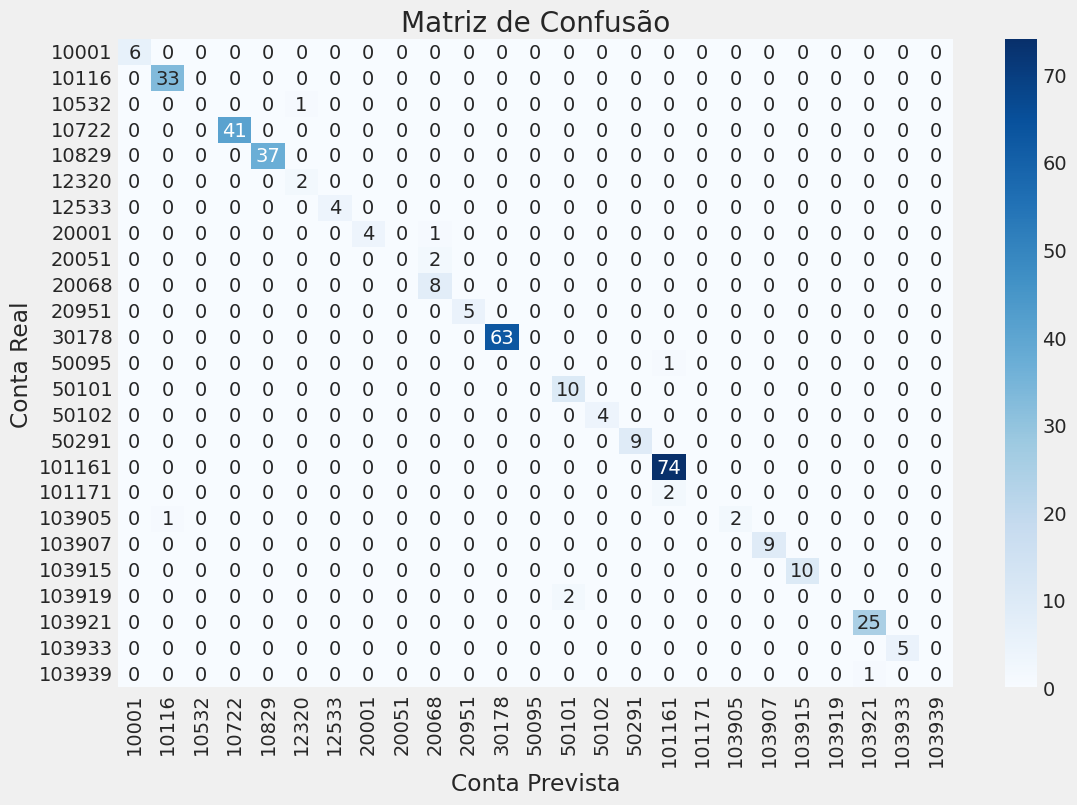

In [25]:
# Avaliando o modelo, criando matriz de confusão e relatório de classificação
# Usando o pipeline para fazer previsões
y_pred = text_clf_pipeline.predict(X_test)
# Imprimindo o relatório de classificação
print("Relatório de Classificação: ")
print(classification_report(y_test, y_pred))
# Gerar e visualizar matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('Conta Real')
plt.xlabel('Conta Prevista')
plt.title('Matriz de Confusão')
plt.show()

## Análise de keywords
Aqui será analisado a distribuição das keywords, dividindo seus resultados em 3 colunas:

- Keyword: são as palavras consideradas como principais na classificação do lançamento
- Frequência total: quantas vezes elas aparecem
- Conta dominante: nas vezes em que aparecem, em quais contas seus lançamentos costumam ser atribuídos
  
Através desses dados, é possível prever quais palavras são mais determinantes e menos ambíguas na hora de realizar a classificação dos lançamentos

In [26]:
# Analisando a distribuição das keywords, verificando se pertencem a mais de uma conta
from tqdm.auto import tqdm # barra de progresso
print("Iniciando análise de palavras-chave...")
df_analysis = df_filtered.copy()
# Extraindo todo o vocabulário
vectorizer_vocab = CountVectorizer(min_df=2)
vectorizer_vocab.fit(df_analysis["DESCRIÇÃO_LIMPA"])
vocab = vectorizer_vocab.get_feature_names_out()
print(f"Vocabulário extraído com {len(vocab)} palavras.")

# Iterar sobre cada palavra e calcular as estatísticas
analysis_list = []
for word in tqdm(vocab, desc="Analisando palavras"):
    # Filtrar linhas que contêm a palavra
    df_word = df_analysis[df_analysis["DESCRIÇÃO_LIMPA"].str.contains(rf'\b{word}\b', regex=True)]
    if not df_word.empty:
        total_freq = len(df_word)
        dist = df_word['CONTA'].value_counts()
        dominant_acc = dist.index[0]
        dominant_freq = dist.iloc[0]
        exclusivity = (dominant_freq / total_freq) * 100
        
        # Guarda os resultados
        analysis_list.append({
            "Keyword": word,
            "Frequência Total": total_freq,
            "Conta dominante": dominant_acc,
            "Frequência na conta dominante": dominant_freq,
            "Exclusividade (%)": exclusivity
        })
# Criando DataFrame com os resultados
df_keyword_analysis = pd.DataFrame(analysis_list)
# Ordenando por exclusividade
df_keyword_analysis_sorted = df_keyword_analysis.sort_values(by="Exclusividade (%)", ascending=True)

# Mostrando as palavras com maior exclusividade
print("Palavras com maior exclusividade:")
print(df_keyword_analysis_sorted.head(50))
print("--------------------------------")
# Menos exclusivas
print("Palavras com menor exclusividade:")
print(df_keyword_analysis_sorted[df_keyword_analysis_sorted["Frequência Total"] > 10].sort_values(by="Exclusividade (%)", ascending=False).head(30))

Iniciando análise de palavras-chave...
Vocabulário extraído com 71 palavras.


Analisando palavras:   0%|          | 0/71 [00:00<?, ?it/s]

Palavras com maior exclusividade:
          Keyword  Frequência Total  Conta dominante  \
37           itaú                40            50102   
4          boleto               168           103921   
23        extrato                34            50102   
54            ref                63            20068   
41           ltda               153           103921   
52            rec                48            20068   
7             cap                13            12320   
5          brasil                24            50101   
18         eireli                17           103933   
50          pinto               137            10829   
16           dias               137            10829   
1       alexandre               137            10829   
11       comercio                12           103921   
69            vlr                14            12533   
31            ind                79           103921   
56        resgate               252           101161   
47  omiexperie

## Probabilidade de previsão
Aqui será mostrado a probabilidade de previsão pela ordem das classes do modelo.

In [27]:
# Probabilidade de previsão e coluna de classificação
print("Calculando probabilidades de previsão")
# Obter a matriz de probabilidades
arr_proba = text_clf_pipeline.predict_proba(X)
# Ordem da classe conforme o modelo
model_classes = text_clf_pipeline.classes_
print(f"Ordem das classes conforme o modelo: {model_classes}")
# Criação do map para encontrar o índice da classe
class_index_map = {cls: i for i, cls in enumerate(model_classes)}
# Para cada linha do dataset, descobrir qual o indice da classe
# Pegando dados de y, que são as contas reais de cada lançamento
index_real_cls = y.map(class_index_map).values
# Calculando a probabilidade da classe real para cada linha
real_proba = arr_proba[np.arange(len(y)), index_real_cls]
# Criando coluna no DataFrame
df_filtered.loc[:, 'CLASSIFICAÇÃO_PROB'] = real_proba * 100

# Mostrando o resultado final
print("\nResultado final...")
df_display = df_filtered.copy()
df_display['CLASSIFICAÇÃO_PROB'] = df_display['CLASSIFICAÇÃO_PROB'].map('{:.2f}%'.format)

# Exibir colunas mais importantes
columns_to_display = ['DESCRIÇÃO DO LANÇAMENTO', 'DESCRIÇÃO_LIMPA', 'CLASSIFICAÇÃO_PROB']
print(df_display[columns_to_display].head(20))

Calculando probabilidades de previsão
Ordem das classes conforme o modelo: [ 10001  10116  10532  10722  10829  12320  12533  20001  20051  20068
  20951  30178  50095  50101  50102  50291 101161 101171 103905 103907
 103915 103919 103921 103933 103939]

Resultado final...
                              DESCRIÇÃO DO LANÇAMENTO  \
0     PAGTO. BOLETO - ENDURANCE GROUP B H SITES LTDA    
1                          VR. RESGATE DE APLICAÇÕES    
2   PAGTO. BOLETO - 33821 ANGLO INDUSTRIA E COMERC...   
3                          VR. RESGATE DE APLICAÇÕES    
4                        VR. RENDIMENTO S/APLICAÇÕES    
5            PAGTO. DE LUCROS A ALEXANDRE PINTO DIAS    
6                         VR. APLICAÇÕES.CF.EXTRATOS    
7                                 RECEBTO.DUPLICATAS    
8             PAGTO. NF. 1399744 OMIEXPERIENCE LTDA.    
9                          VR. RESGATE DE APLICAÇÕES    
10                       VR. RENDIMENTO S/APLICAÇÕES    
11         PAGTO. NF. 5366 ESCRITORIO CLAU

/tmp/ipykernel_5896/3062206852.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'CLASSIFICAÇÃO_PROB'] = real_proba * 100


## Testando inserção de dados
Testada uma nova entrada e retornando a probabilidade de previsão. Nota-se que a probabilidade de previsão vai diminuindo conforme o modelo aprende mais das contas.

In [28]:
# Testando com novo lançamento
new_entries = ["pagto alexandre dias"]
# Limpando os novos lançamentos
new_entries_clean = clean_text(new_entries)
# Fazendo previsões
proba = text_clf_pipeline.predict_proba([new_entries_clean])
# Obtendo classes previstas
classes = text_clf_pipeline.classes_
# DataFrame mostrando resultados. O .T deixa as contas como linhas
df_results = pd.DataFrame(proba, columns=classes).T
df_results.rename(columns={0: 'Probabilidade'}, inplace=True)
# Convertendo para porcentagem
df_results['Probabilidade'] = df_results['Probabilidade'] * 100
# Ordenando da maior para a menor probabilidade
df_results_sorted = df_results.sort_values(by='Probabilidade', ascending=False)
df_results_sorted['Probabilidade'] = df_results_sorted['Probabilidade'].map('{:.2f}%'.format) 
print("Resultados das previsões para novos lançamentos:")
print(df_results_sorted)

# Mostrando a melhor e pior previsão do modelo
print("Analisando a melhor previsão do modelo...")
# Encontrando a melhor previsão
best_acc = df_results_sorted.iloc[0]
best_proba = df_results_sorted.iloc[0,0]
print(f"Melhor previsão: Conta {best_acc.name} com probabilidade de {best_proba}")

Resultados das previsões para novos lançamentos:
       Probabilidade
10829         91.50%
20951          1.37%
101161         0.90%
30178          0.89%
10116          0.79%
10722          0.63%
103921         0.40%
50291          0.37%
103907         0.33%
103915         0.33%
50101          0.31%
20068          0.29%
10001          0.27%
50102          0.20%
20001          0.20%
103933         0.19%
12533          0.18%
12320          0.14%
103905         0.13%
50095          0.10%
101171         0.10%
20051          0.10%
10532          0.10%
103939         0.09%
103919         0.09%
Analisando a melhor previsão do modelo...
Melhor previsão: Conta 10829 com probabilidade de 91.50%


In [29]:
# Salvando modelo treinado
import joblib
model_name = 'modelo_contabil_pipeline.joblib'
joblib.dump(text_clf_pipeline, model_name)
print(f"Modelo salvo em {model_name}")

Modelo salvo em modelo_contabil_pipeline.joblib


## Testando o modelo já salvo
Repetindo os testes anteriores, mas agora usando o modelo salvo.

In [30]:
# Testando modelo salvo
load_model = joblib.load(model_name)
test_entry = ["TESTE. pagto alexandre dias"]
# Usando modelo carregado para fazer previsão
predict = load_model.predict(test_entry)
proba = load_model.predict_proba(test_entry)
# Pega a probabilidade da classe prevista
max_prob = proba.max()

print("\nTestando modelo salvo...")
print(f"O lançamento '{test_entry[0]}' foi classificado na conta '{predict[0]}' com probabilidade de {max_prob*100:.2f}%")


Testando modelo salvo...
O lançamento 'TESTE. pagto alexandre dias' foi classificado na conta '10829' com probabilidade de 91.50%


In [31]:
# Testando modelo para preencher as contas de lançamentos sem classificação
blank_sheet = 'teste_contabeis_preencher.xlsx'
df = pd.read_excel(blank_sheet)
df.head(5)

# Definindo as colunas e separando os dataframes 
col_his = 'DESCRIÇÃO DO LANÇAMENTO'
col_acc = 'CONTA'  # Coluna onde a conta será preenchida

# Condição para separar treino e classificação
condition_for_class = df[col_acc].isna() | (df[col_acc].astype(str).str.strip() == '')
# DataFrame para classificar
df_for_class = df[condition_for_class].copy()
# DF para treino usando o inverso da condição (~)
df_training = df[~condition_for_class].copy() 
# Verificando os resultados obtidos
print("\n--- Separação de dados concluída ---")
print(f"Total de lançamentos carregados: {len(df)}")
print(f"Lançamentos para TREINO: {len(df_training)}")
print(f"Lançamentos para CLASSIFICAÇÃO: {len(df_for_class)}")

if len(df) == (len(df_training) + len(df_for_class)):
    print("A soma dos lançamentos para treino e classificação confere com o total carregado.")
else:
    print("Atenção: A soma dos lançamentos para treino e classificação NÃO confere com o total carregado.")


--- Separação de dados concluída ---
Total de lançamentos carregados: 1272
Lançamentos para TREINO: 1256
Lançamentos para CLASSIFICAÇÃO: 16
A soma dos lançamentos para treino e classificação confere com o total carregado.


In [32]:
# treinando modelo com regressão
# filtrando df
acc_count = df_training[col_acc].value_counts()
cutoff = 7
valid_acc = acc_count[acc_count >= cutoff].index
df_filtered = df_training[df_training[col_acc].isin(valid_acc)].copy()

df_filtered[col_acc] = df_filtered[col_acc].astype(int) 
df_filtered["DESCRIÇÃO_LIMPA"] = df_filtered[col_his].apply(clean_text)
X = df_filtered["DESCRIÇÃO_LIMPA"]
y = df_filtered[col_acc]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Dados de treino divididos: {len(X_train)} para treino e {len(X_test)} para teste")

from sklearn.linear_model import LogisticRegression
# Definir e criar pipeline
text_clf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('clf', LogisticRegression(random_state=42)),
    ])
print("Treinando o modelo...")
text_clf_pipeline.fit(X_train, y_train)
print("Modelo treinado com sucesso!")

Dados de treino divididos: 821 para treino e 352 para teste
Treinando o modelo...
Modelo treinado com sucesso!


Relatório de Classificação: 
              precision    recall  f1-score   support

       10001       1.00      1.00      1.00         6
       10116       1.00      1.00      1.00        33
       10722       1.00      1.00      1.00        41
       10829       1.00      1.00      1.00        37
       12320       1.00      1.00      1.00         2
       12533       1.00      1.00      1.00         4
       20001       1.00      1.00      1.00         4
       20068       1.00      1.00      1.00         8
       20951       1.00      1.00      1.00         5
       30178       1.00      1.00      1.00        63
       50101       1.00      1.00      1.00        10
       50102       1.00      1.00      1.00         4
       50291       1.00      1.00      1.00         9
      101161       1.00      1.00      1.00        74
      103905       1.00      1.00      1.00         3
      103907       1.00      1.00      1.00         9
      103915       1.00      1.00      1.00        1

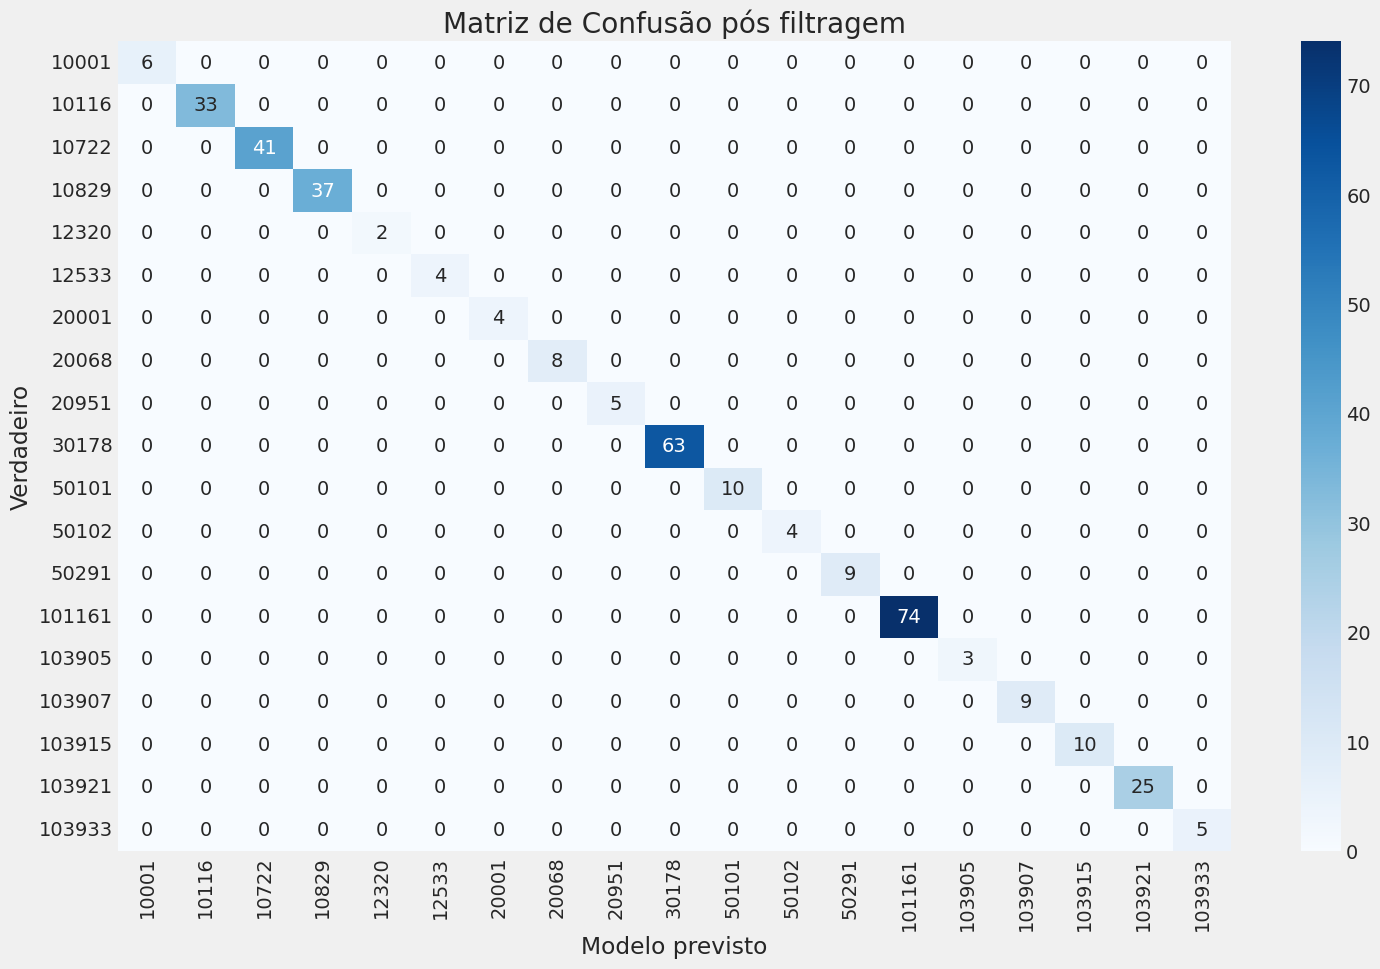

In [33]:
# Avaliando novo modelo
# Avaliando o modelo, criando matriz de confusão e relatório de classificação
# Usando o pipeline para fazer previsões
y_pred = text_clf_pipeline.predict(X_test)
# Imprimindo o relatório de classificação
print("Relatório de Classificação: ")
print(classification_report(y_test, y_pred))
# Gerar e visualizar matriz de confusão
print("Matriz de Confusão:")
conf_matrix = confusion_matrix(y_test, y_pred)
labels = sorted(y_test.unique())
plt.figure(figsize=(16, 10))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.ylabel("Verdadeiro")
plt.xlabel("Modelo previsto")
plt.title("Matriz de Confusão pós filtragem")
plt.show()

In [34]:
# Aplicando regra de negócio para preencher as contas
# Iniciando o processo de classificação
print("Iniciando o processo de classificação...")
classify_texts = df_for_class[col_his].apply(clean_text)
# usando o modelo para fazer as probabilidades
arr_proba = text_clf_pipeline.predict_proba(classify_texts)
# Processar os resultados e aplicar a regra de negócio
fill_accounts = []
final_proba = []
confidence_limit = 0.70 # critério de 70%

for i in range(len(arr_proba)):
    # pega as probabilidades para o lançamento atual
    lanc_proba = arr_proba[i]
    # encontra o indice da maior probabilidade
    best_acc_index = lanc_proba.argmax()
    # valor da maior probabilidade
    max_proba = lanc_proba[best_acc_index]
    # pega o código da conta
    predicted_acc = text_clf_pipeline.classes_[best_acc_index]
    # aplica a regra de negócio
    if max_proba >= confidence_limit:
        fill_accounts.append(predicted_acc)
        final_proba.append(max_proba * 100) # convertendo para porcentagem
    else:
        fill_accounts.append(f"Revisar") # não preencher
        final_proba.append(f"Sugestão: {predicted_acc} ({max_proba:.2%})") # convertendo para porcentagem
        
# Adicionando os resultados ao DataFrame original
df_for_class['CONTA'] = fill_accounts
df_for_class['CLASSIFICAÇÃO_PROB'] = final_proba

print("\nClassificação concluída. Resultados:")
print(df_for_class[[col_his, 'CONTA', 'CLASSIFICAÇÃO_PROB']].head(20))

Iniciando o processo de classificação...

Classificação concluída. Resultados:
                                DESCRIÇÃO DO LANÇAMENTO   CONTA  \
1256    PAGTO. BOLETO - ENDURANCE GROUP B H SITES LTDA    50101   
1257                         VR. RESGATE DE APLICAÇÕES   101161   
1258  PAGTO. BOLETO - 33821 ANGLO INDUSTRIA E COMERC...  103921   
1259                         VR. RESGATE DE APLICAÇÕES   101161   
1260                       VR. RENDIMENTO S/APLICAÇÕES    30178   
1261           PAGTO. DE LUCROS A ALEXANDRE PINTO DIAS    10829   
1262                        VR. APLICAÇÕES.CF.EXTRATOS    10116   
1263                                RECEBTO.DUPLICATAS    10722   
1264            PAGTO. NF. 1399744 OMIEXPERIENCE LTDA.   103907   
1265                         VR. RESGATE DE APLICAÇÕES   101161   
1266                       VR. RENDIMENTO S/APLICAÇÕES    30178   
1267         PAGTO. NF. 5366 ESCRITORIO CLAUDIO CRU SS   103915   
1268                         VR. RESGATE DE APLICA

In [35]:
# Gerando planilha final com os resultados
df_final = pd.concat([df_training, df_for_class], ignore_index=True)
output_file = 'classificacao_contas_resultado.xlsx'
df_final.to_excel(output_file, index=False)
print(f"\nPlanilha final salva como '{output_file}' com {len(df_final)} lançamentos.")


Planilha final salva como 'classificacao_contas_resultado.xlsx' com 1272 lançamentos.
